In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


activities_df = pd.read_csv('data/activities_small.csv', encoding='utf-8')
zero_dist_mask = activities_df['distance'] > 0
activities_df = activities_df[zero_dist_mask]
# activities_df.drop('index', 1, inplace=True)
runs_df = activities_df[activities_df.type == 'Run']
rides_df = activities_df[activities_df.type == 'Ride']

In [6]:
activities_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9908 entries, 0 to 9924
Data columns (total 40 columns):
id                        9908 non-null int64
name                      9907 non-null object
distance                  9908 non-null float64
moving_time               9908 non-null float64
elapsed_time              9908 non-null float64
total_elevation_gain      9908 non-null float64
type                      9908 non-null object
start_date                9908 non-null object
start_date_local          9908 non-null object
timezone                  9908 non-null object
achievement_count         9908 non-null int64
kudos_count               9908 non-null int64
comment_count             9908 non-null int64
athlete_count             9908 non-null int64
photo_count               9908 non-null int64
total_photo_count         9908 non-null int64
trainer                   9908 non-null bool
commute                   9908 non-null bool
manual                    9908 non-null bool
private  

Let us focus on the rides dataframe. First lets get out only activities in Colorado. This data frame is relatively small and consists of mostly my ride history. I will have way more once I have scraped more. These are just activities immediately available to me via the strava api.

In [11]:
co_rides_mask = rides_df['state'] == 'Colorado'
co_runs_mask = runs_df['state'] == 'Colorado'
co_rides_df = rides_df[co_rides_mask].reset_index(drop=True).fillna(0)
co_runs_df = runs_df[co_runs_mask].reset_index(drop=True).fillna(0)
print co_rides_df.shape
print co_runs_df.shape

(5902, 40)
(1325, 40)


Now it's time to make clusters of rides with same general starting latitude and longitude, ending latitude and longitude, distance and total elevation gain.

In [12]:
X = co_rides_df[['distance', 'total_elevation_gain', 'start_lat', 'start_lng', 'end_lat', 'end_lng']].values
# X = co_runs_df[['distance', 'total_elevation_gain', 'start_lat', 'start_lng', 'end_lat', 'end_lng']].values

In [13]:
k=10

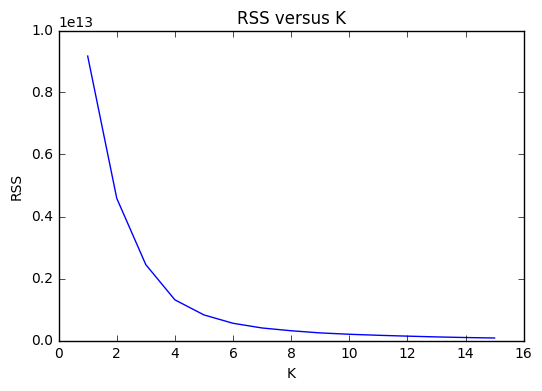

In [14]:
from sklearn.cluster import KMeans
ncluster_list = range(1,16)

def kmean_score(nclust):
    km = KMeans(nclust)
    km.fit(X)
    rss = -km.score(X)
    return rss
scores = [kmean_score(i) for i in range(1,16)]
plt.plot(range(1,16), scores)
plt.xlabel('K')
plt.ylabel('RSS')
plt.title('RSS versus K')
plt.show()

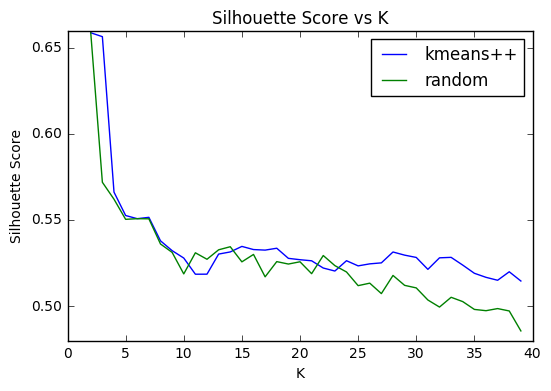

In [15]:
n_samples, n_features = X.shape
def get_silhouette_score(estimator):
    km = estimator
    km.fit(X)
    sil_avg = metrics.silhouette_score(X, km.labels_)
    return sil_avg

def get_estimators(n):
    estimators = [KMeans(init='k-means++', n_clusters=n, n_init=10),
                   KMeans(init='random', n_clusters=n, n_init=10)]
    return estimators

scores_arr = []
for n in range(2, 40):
    sil_scores = [get_silhouette_score(estimator) for estimator in get_estimators(n)]
    scores_arr.append(sil_scores)

plt.plot(range(2, 40), np.array(scores_arr)[:, 0])
plt.plot(range(2, 40), np.array(scores_arr)[:, 1])    
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs K')
plt.legend(['kmeans++', 'random'])
plt.show()


This method of evaluating the number of clusters always leads to improbable numbers of clusters. With 676 rides in the dataframe(most being mine) it is to be expected that there should be more than 12-16 rides which is number i get which has the silhoutte score on average.

In [17]:
X = StandardScaler().fit_transform(X)

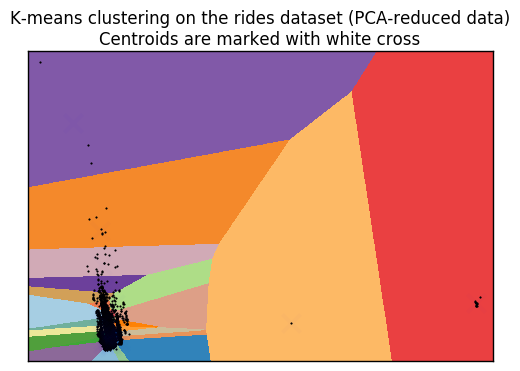

In [18]:
reduced_data = PCA(n_components=2).fit_transform(X)
kmeans = KMeans(init='random', n_clusters=50, n_init=10).fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            cmap='prism', zorder=10, alpha=.01)
plt.title('K-means clustering on the rides dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [20]:
from clustering import *
from setup import *
co_runs_df, co_rides_df = get_labels(co_runs_df, co_rides_df)
n_labels = len(co_rides_df.label.unique())
athlete_ids = np.array(sorted(co_rides_df.athlete_id.unique()))
n_athletes = len(athlete_ids)
# co_runs_df = add_closest_city_feature(co_runs_df)
# co_rides_df = add_closest_city_feature(co_rides_df)
co_rides_df.head()

id                                     name  distance  moving_time  \
0  467664896               Fat Bike in the snow at GM   12557.8       4111.0   
1  308543489  05/19/2015 Fruita, CO Horse Thief Bench   15941.8       3448.0   
2  432799746                               Lunch Ride   77276.3      10158.0   
3  404750345                        Truck lot commute   19340.0       2261.0   
4  308543507          05/20/2015 Fruita, CO Edge Loop   53577.9      14160.0   

   elapsed_time  total_elevation_gain  type                 start_date  \
0        4193.0                 419.4  Ride  2016-01-10 19:13:47+00:00   
1        4356.0                 322.0  Ride  2015-05-20 00:41:46+00:00   
2       15286.0                 962.0  Ride  2015-11-14 19:21:32+00:00   
3        2404.0                  25.9  Ride  2015-10-02 13:59:13+00:00   
4       19563.0                1355.0  Ride  2015-05-20 15:55:46+00:00   

      start_date_local        timezone  ...   athlete_id      map_id  \
0  2016-01-10 12:13:47  America/Denver  ...      7360660  a467664896   
1  2015-05-19 18:41:46  America/Denver  ...       113571  a308543489   
2  2015-11-14 12:21:32  America/Denver  ...        67365  a432799746   
3  2015-10-02 07:59:13  America/Denver  ...       606184  a404750345   
4  2015-05-20 09:55:46  America/Denver  ...       113571  a308543507   

                                map_summary_polyline  start_lat  start_lng  \
0  w`gqFnpx`SDzEkDYw@wBApDdBjBGlD~@~@u@pCgJdD_AdM...      39.69    -105.15   
1  scbnFjbgwSQjMzFhGnAzMJdEgBdBWtDpA`G|NnU`AxImAx...      39.17    -108.83   
2  kf`sFhaiaS}KiBsAtFyI`ByeAjyBqBjNeJt@iC_EcGsAcn...      39.98    -105.24   
3  akotFz{naSHwFdJRna@wh@nGeRbOyUdE{M|@qKaAmw@rXi...      40.22    -105.27   
4  ez|nFrrnvSvRzu@aKhOsw@|FzDxFoKpZlMz_@qBpL}PrCk...      39.31    -108.71   

   end_lat end_lng     state closest_city label  
0    39.69 -105.15  Colorado     Lakewood    21  
1    39.18 -108.83  Colorado       Fruita     3  
2    39.98 -105.24  Colorado      Boulder     9  
3    40.16 -105.10  Colorado        Lyons     1  
4    39.31 -108.71  Colorado       Fruita    35  

[5 rows x 41 columns]

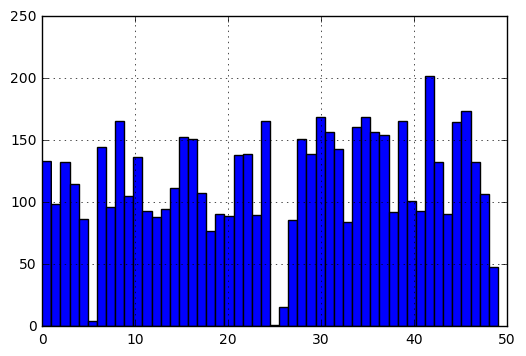

In [21]:
co_rides_df['label'].hist(bins=50)
plt.show()

In [22]:
co_rides_df.groupby(['label', 'closest_city']).count()['id']

label  closest_city     
0      Alma                  1
       Arvada                4
       Aspen                 1
       Black Hawk            1
       Boulder              40
       Bow Mar               3
       Broomfield            2
       Castle Rock           1
       Centennial            1
       Denver                4
       Edgewater             6
       Erie                  1
       Fort Collins         11
       Glendale             17
       Golden                4
       Greenwood Village     2
       Idaho Springs         1
       Kiowa                 1
       Lafayette             1
       Lakeside              3
       Lakewood              2
       Leadville             1
       Littleton             7
       Lone Tree             2
       Longmont              2
       Louisville            3
       Lyons                 1
       Monument              1
       Mountain View         5
       Silverthorne          1
                            ..
48     Manitou

The following will be explicitly for the rides dataframe. I am going to assume all methods will work on the runs_df as well.

In [23]:
ath_labels = co_rides_df.groupby(['athlete_id', 'label']).count()['id'].to_dict()

In [24]:
ath_labels

{(309548, 15): 1,
 (1343001, 31): 1,
 (119864, 38): 2,
 (3216993, 16): 1,
 (1514935, 33): 1,
 (1870533, 24): 1,
 (519225, 39): 6,
 (7787, 32): 2,
 (2381506, 32): 1,
 (250367, 22): 3,
 (172742, 23): 2,
 (15896021, 49): 1,
 (645904, 14): 1,
 (373166, 8): 1,
 (773191, 9): 1,
 (12802, 48): 1,
 (616558, 34): 1,
 (442473, 20): 2,
 (5011471, 3): 2,
 (321292, 37): 1,
 (2520729, 0): 3,
 (734377, 43): 2,
 (624147, 3): 9,
 (6808641, 13): 1,
 (126211, 16): 1,
 (608971, 15): 1,
 (134921, 24): 2,
 (153343, 10): 1,
 (241087, 1): 2,
 (51905, 21): 1,
 (2524666, 1): 1,
 (606184, 12): 2,
 (1558187, 30): 3,
 (109938, 14): 1,
 (373493, 29): 1,
 (246788, 16): 1,
 (68539, 16): 1,
 (788596, 28): 1,
 (198626, 33): 1,
 (508882, 8): 2,
 (104852, 36): 3,
 (55375, 47): 4,
 (603528, 47): 1,
 (104852, 29): 1,
 (10799453, 39): 1,
 (734377, 20): 1,
 (303378, 48): 1,
 (1633622, 27): 1,
 (624147, 16): 1,
 (589128, 29): 1,
 (101792, 37): 1,
 (101792, 8): 1,
 (2520729, 9): 1,
 (62154, 9): 1,
 (255282, 10): 1,
 (1412833, 2

In [25]:
ratings = np.zeros((n_athletes, n_labels))
for k,v in ath_labels.iteritems():
    ratings[np.where(athlete_ids==k[0])[0][0], k[1]] = v

In [58]:
np.set_printoptions(threshold=5)

In [27]:
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
print 'Sparsity: {:4.2f}%'.format(sparsity)

Sparsity: 8.87%


Most of this code is from ethan rosenthals blog at: http://blog.ethanrosenthal.com/2015/11/02/intro-to-collaborative-filtering/. More to add on this later....

In [29]:
# gordons_rides.groupby('label').count()['id'].sort_values('index', ascending=0).hist(bins=15)
# plt.show()

In [31]:
# gordons_rides = co_rides_df.loc[co_rides_df.athlete_id==7202879, :]
# data = gordons_rides.groupby('label').count()['id'].sort_values('index', ascending=0).values

# from scipy.optimize import curve_fit
# from scipy.misc import factorial


# # get poisson deviated random numbers
# # data = np.random.poisson(2, 1000)

# # the bins should be of integer width, because poisson is an integer distribution
# entries, bin_edges, patches = plt.hist(data, bins=12, range=[-0.5, 15], normed=True)

# # calculate binmiddles
# bin_middles = 0.5*(bin_edges[1:] + bin_edges[:-1])

# # poisson function, parameter lamb is the fit parameter
# def poisson(k, lamb):
#     return (lamb**k/factorial(k)) * np.exp(-lamb)

# # fit with curve_fit
# parameters, cov_matrix = curve_fit(poisson, bin_middles, entries) 

# # plot poisson-deviation with fitted parameter
# x_plot = np.linspace(0, 20, 1000)

# plt.plot(x_plot, poisson(x_plot, *parameters), 'r-', lw=2)
# plt.show()
# lam = parameters[0]

In [32]:
# # randomized ratings matrix. Spoofed to remove spacity
# ratings = np.random.poisson(lam=lam, size=(n_athletes, n_labels))

# sparsity = float(len(ratings.nonzero()[0]))
# sparsity /= (ratings.shape[0] * ratings.shape[1])
# sparsity *= 100
# print 'Sparsity: {:4.2f}%'.format(sparsity)

# ratings

In [37]:
def train_test_split(ratings):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in xrange(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], 
                                        size=10, 
                                        replace=True)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
        
    # Test and training are truly disjoint
    assert(np.all((train * test) == 0)) 
    return train, test

Can't do a train test split with data till there are more ratings per user. When I use the bigger data set this shouldn't be a problem. For the following collaborative filtering model, I will use the entire ratings matrix.

In [38]:
train, test = train_test_split(ratings)

In [39]:
def fast_similarity(ratings, kind='user', epsilon=1e-9):
    # epsilon -> small number for handling dived-by-zero errors
    if kind == 'user':
        sim = ratings.dot(ratings.T) + epsilon
    elif kind == 'item':
        sim = ratings.T.dot(ratings) + epsilon
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return (sim / norms / norms.T)

In [40]:
user_similarity = fast_similarity(ratings, kind='user')
item_similarity = fast_similarity(ratings, kind='item')
print item_similarity[:4, :4]

[[ 1.          0.10826639  0.27371993  0.07127715]
 [ 0.10826639  1.          0.39737398  0.31119318]
 [ 0.27371993  0.39737398  1.          0.30768698]
 [ 0.07127715  0.31119318  0.30768698  1.        ]]


In [41]:
def predict_fast_simple(ratings, similarity, kind='user'):
    if kind == 'user':
        return similarity.dot(ratings) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif kind == 'item':
        return ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])

In [42]:
from sklearn.metrics import mean_squared_error

def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

In [43]:
item_prediction = predict_fast_simple(train, item_similarity, kind='item')
user_prediction = predict_fast_simple(train, user_similarity, kind='user')

print 'User-based CF MSE: ' + str(get_mse(user_prediction, test))
print 'Item-based CF MSE: ' + str(get_mse(item_prediction, test))

User-based CF MSE: 4.40860531058
Item-based CF MSE: 4.32275679495


In [44]:
def predict_topk(ratings, similarity, kind='user', k=40):
    pred = np.zeros(ratings.shape)
    if kind == 'user':
        for i in xrange(ratings.shape[0]):
            top_k_users = [np.argsort(similarity[:,i])[:-k-1:-1]]
            for j in xrange(ratings.shape[1]):
                pred[i, j] = similarity[i, :][top_k_users].dot(ratings[:, j][top_k_users]) 
                pred[i, j] /= np.sum(np.abs(similarity[i, :][top_k_users]))
    if kind == 'item':
        for j in xrange(ratings.shape[1]):
            top_k_items = [np.argsort(similarity[:,j])[:-k-1:-1]]
            for i in xrange(ratings.shape[0]):
                pred[i, j] = similarity[j, :][top_k_items].dot(ratings[i, :][top_k_items].T) 
                pred[i, j] /= np.sum(np.abs(similarity[j, :][top_k_items]))        
    
    return pred

In [45]:
pred = predict_topk(train, user_similarity, kind='user', k=40)
print 'Top-k User-based CF MSE: ' + str(get_mse(pred, test))

pred = predict_topk(train, item_similarity, kind='item', k=40)
print 'Top-k Item-based CF MSE: ' + str(get_mse(pred, test))

Top-k User-based CF MSE: 4.07855361995
Top-k Item-based CF MSE: 4.28944563091


In [46]:
k_array = [5, 15, 30, 50, 100, 200]
user_train_mse = []
user_test_mse = []
item_test_mse = []
item_train_mse = []

def get_mse(pred, actual):
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

for k in k_array:
    user_pred = predict_topk(train, user_similarity, kind='user', k=k)
    item_pred = predict_topk(train, item_similarity, kind='item', k=k)
    
    user_train_mse += [get_mse(user_pred, train)]
    user_test_mse += [get_mse(user_pred, test)]
    
    item_train_mse += [get_mse(item_pred, train)]
    item_test_mse += [get_mse(item_pred, test)]  

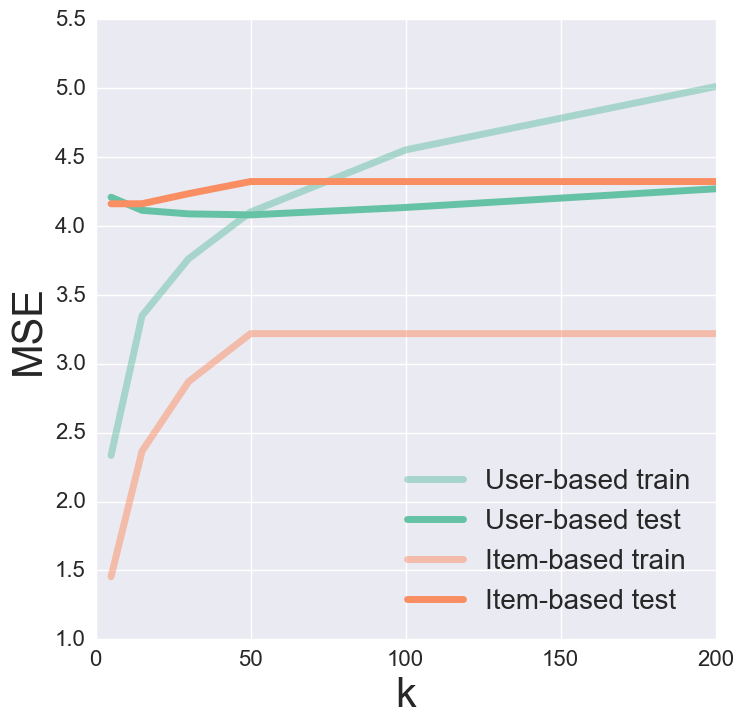

In [47]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

pal = sns.color_palette("Set2", 2)

plt.figure(figsize=(8, 8))
plt.plot(k_array, user_train_mse, c=pal[0], label='User-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, user_test_mse, c=pal[0], label='User-based test', linewidth=5)
plt.plot(k_array, item_train_mse, c=pal[1], label='Item-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, item_test_mse, c=pal[1], label='Item-based test', linewidth=5)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('k', fontsize=30);
plt.ylabel('MSE', fontsize=30);

In [48]:
def predict_nobias(ratings, similarity, kind='user'):
    if kind == 'user':
        user_bias = ratings.mean(axis=1)
        ratings = (ratings - user_bias[:, np.newaxis]).copy()
        pred = similarity.dot(ratings) / np.array([np.abs(similarity).sum(axis=1)]).T
        pred += user_bias[:, np.newaxis]
    elif kind == 'item':
        item_bias = ratings.mean(axis=0)
        ratings = (ratings - item_bias[np.newaxis, :]).copy()
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
        pred += item_bias[np.newaxis, :]
        
    return pred

In [49]:
user_pred = predict_nobias(train, user_similarity, kind='user')
print 'Bias-subtracted User-based CF MSE: ' + str(get_mse(user_pred, test))

item_pred = predict_nobias(train, item_similarity, kind='item')
print 'Bias-subtracted Item-based CF MSE: ' + str(get_mse(item_pred, test))

Bias-subtracted User-based CF MSE: 4.14605309151
Bias-subtracted Item-based CF MSE: 4.31729464949


In [50]:
def predict_topk_nobias(ratings, similarity, kind='user', k=40):
    pred = np.zeros(ratings.shape)
    if kind == 'user':
        user_bias = ratings.mean(axis=1)
        ratings = (ratings - user_bias[:, np.newaxis]).copy()
        for i in xrange(ratings.shape[0]):
            top_k_users = [np.argsort(similarity[:,i])[:-k-1:-1]]
            for j in xrange(ratings.shape[1]):
                pred[i, j] = similarity[i, :][top_k_users].dot(ratings[:, j][top_k_users]) 
                pred[i, j] /= np.sum(np.abs(similarity[i, :][top_k_users]))
        pred += user_bias[:, np.newaxis]
    if kind == 'item':
        item_bias = ratings.mean(axis=0)
        ratings = (ratings - item_bias[np.newaxis, :]).copy()
        for j in xrange(ratings.shape[1]):
            top_k_items = [np.argsort(similarity[:,j])[:-k-1:-1]]
            for i in xrange(ratings.shape[0]):
                pred[i, j] = similarity[j, :][top_k_items].dot(ratings[i, :][top_k_items].T) 
                pred[i, j] /= np.sum(np.abs(similarity[j, :][top_k_items])) 
        pred += item_bias[np.newaxis, :]
        
    return pred

In [51]:
k_array = [5, 15, 30, 50, 100, 200]
user_train_mse = []
user_test_mse = []
item_test_mse = []
item_train_mse = []

for k in k_array:
    user_pred = predict_topk_nobias(train, user_similarity, kind='user', k=k)
    item_pred = predict_topk_nobias(train, item_similarity, kind='item', k=k)
    
    user_train_mse += [get_mse(user_pred, train)]
    user_test_mse += [get_mse(user_pred, test)]
    
    item_train_mse += [get_mse(item_pred, train)]
    item_test_mse += [get_mse(item_pred, test)]  

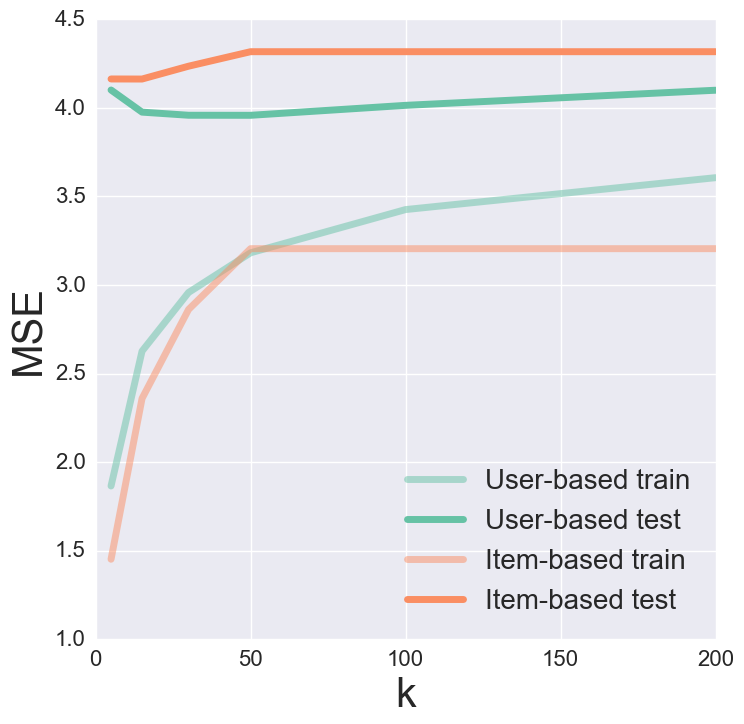

In [52]:
pal = sns.color_palette("Set2", 2)

plt.figure(figsize=(8, 8))
plt.plot(k_array, user_train_mse, c=pal[0], label='User-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, user_test_mse, c=pal[0], label='User-based test', linewidth=5)
plt.plot(k_array, item_train_mse, c=pal[1], label='Item-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, item_test_mse, c=pal[1], label='Item-based test', linewidth=5)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('k', fontsize=30);
plt.ylabel('MSE', fontsize=30);

In [53]:
idx_to_rides = {}
df_groupby = co_rides_df.groupby(['label', 'id'])['label'].agg({'Frequency':'count'}).to_dict('series')['Frequency']
for label in np.sort(co_rides_df['label'].unique()):
    idx_to_rides[label] = df_groupby[label].index.values


def top_k_labels(similarity, mapper, label_idx, k=3):
    return [mapper[x] for x in np.argsort(similarity[label_idx,:])[:-k-1:-1]]

In [54]:
idx = 0
rides = top_k_labels(item_similarity, idx_to_rides, idx)

In [55]:
rides

[array([108266046, 124020621, 125072627, ..., 871388150, 871389091,
        871397962]),
 array([  2364136, 107493569, 109335684, ..., 864555867, 864569954,
        871369264]),
 array([ 13388213, 103040949, 108029550, ..., 839671692, 849623084,
        850928999])]